/var/folders/36/xfvf6zw53bd2ht35p52k28qh0000gn/T/ipykernel_60281/4211939566.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Epoch 0, Loss: 0.7043383121490479
Epoch 10, Loss: -0.1325761079788208
Epoch 20, Loss: -0.23118239641189575
Epoch 30, Loss: -0.3704449534416199
Epoch 40, Loss: -0.5466668009757996
Epoch 50, Loss: -0.7187252640724182
Epoch 60, Loss: -0.8913764953613281
Epoch 70, Loss: -1.0720866918563843
Epoch 80, Loss: -1.2706233263015747
Epoch 90, Loss: -1.4910082817077637


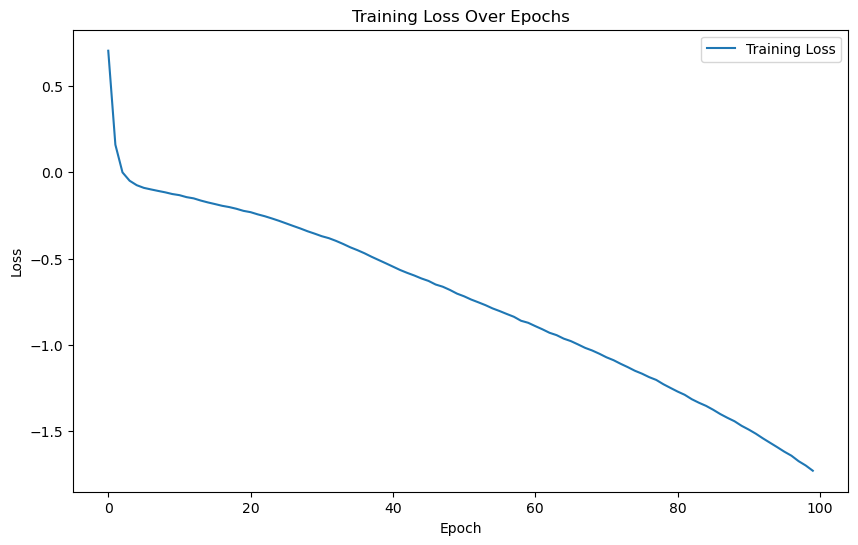

Accuracy: 93.70%
Precision: 0.94
Recall: 0.94
F1-score: 0.94


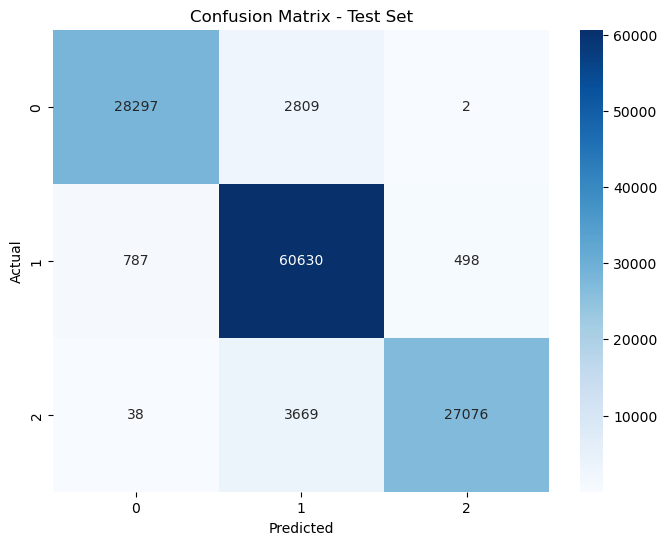

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess dataset
data = pd.read_csv('archive-2/all_stocks_5yr.csv')
data['price_change'] = data['close'].pct_change() * 100
data['date'] = pd.to_datetime(data['date'])

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Enhanced Feature Engineering with financial-specific indicators
for lag in range(1, 4):
    data[f'price_change_lag_{lag}'] = data['price_change'].shift(lag)
data['MA_7'] = data['close'].rolling(window=7).mean()
data['MA_14'] = data['close'].rolling(window=14).mean()
data['Volatility_7'] = data['close'].rolling(window=7).std()
data['Volatility_14'] = data['close'].rolling(window=14).std()
data['momentum_5'] = data['close'] - data['close'].shift(5)

# Additional technical indicators
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']

# Drop NaNs
data.dropna(inplace=True)

# Define event classification based on price change thresholds
lower_threshold = data['price_change'].quantile(0.25)
upper_threshold = data['price_change'].quantile(0.75)
data['event'] = data['price_change'].apply(lambda x: 2 if x >= upper_threshold else (0 if x <= lower_threshold else 1))

# Calculate time deltas in seconds
data['time_delta'] = data['date'].diff().dt.total_seconds().fillna(0)

# Scale features and split data
features = ['price_change', 'MA_7', 'MA_14', 'Volatility_7', 'Volatility_14', 'momentum_5', 'RSI_14', 'MACD', 'time_delta'] + \
           [f'price_change_lag_{lag}' for lag in range(1, 4)]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

X_train, X_test, y_train, y_test = train_test_split(scaled_features, data['event'], test_size=0.2, random_state=42)
train_time_deltas = torch.tensor(X_train[:, features.index('time_delta')]).float()
test_time_deltas = torch.tensor(X_test[:, features.index('time_delta')]).float()

# Convert to PyTorch tensors
train_inputs = torch.tensor(X_train).float()
train_events = torch.tensor(y_train.values).long()
test_inputs = torch.tensor(X_test).float()
test_events = torch.tensor(y_test.values).long()

# Clustering for embedding initialization
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_train)
train_clusters = torch.tensor(kmeans.labels_).long()

# Cluster-Aware Transformer NTPP Model with Time Encoding and KL Divergence Regularization
class ClusterAwareTransformerNTPP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_clusters, num_heads):
        super(ClusterAwareTransformerNTPP, self).__init__()
        
        # Cluster embedding layer
        self.cluster_embedding = nn.Embedding(num_clusters, input_dim)
        
        # Transformer encoder with multi-scale time embedding
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, batch_first=True, dropout=0.3)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Decay parameter for time embeddings
        self.time_decay = nn.Parameter(torch.ones(input_dim))
        
        # Final layers for intensity and mark prediction
        self.intensity_layer = nn.Linear(input_dim, 1)
        self.mark_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x, time_deltas, cluster_ids):
        # Obtain cluster embeddings and ensure dimensions align
        cluster_embed = self.cluster_embedding(cluster_ids)
        
        # Apply decay to time embeddings with multi-scale approach
        time_encoding = torch.exp(-self.time_decay * time_deltas.unsqueeze(-1)) * cluster_embed
        x = x + time_encoding
        x = x.unsqueeze(1)  # [batch_size, sequence_len=1, input_dim]
        
        # Pass through Transformer
        transformer_out = self.transformer(x)
        pooled_output = transformer_out.mean(dim=1)
        
        # Predict intensity and mark
        time_intensity = torch.exp(self.intensity_layer(pooled_output)).squeeze(-1)
        mark_logits = self.mark_layer(pooled_output)
        
        return time_intensity, mark_logits

# Loss function for NTPPs with KL Divergence Regularization
def ntpp_loss(time_intensity, mark_logits, times, marks, alpha=0.1):
    time_loss = -torch.log(time_intensity + 1e-8) + time_intensity * times
    criterion = nn.CrossEntropyLoss()
    mark_loss = criterion(mark_logits, marks)
    # KL Divergence regularization
    kl_loss = alpha * torch.mean(time_intensity)  # Regularization
    return time_loss.mean() + mark_loss + kl_loss

# Initialize model, optimizer
input_dim = train_inputs.shape[1]
hidden_dim = 64
output_dim = 3
num_heads = 2
model = ClusterAwareTransformerNTPP(input_dim, hidden_dim, output_dim, num_clusters, num_heads)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop with gradient clipping and KL regularization
epochs = 100
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    time_intensity, mark_logits = model(train_inputs, train_time_deltas, train_clusters)
    loss = ntpp_loss(time_intensity, mark_logits, train_time_deltas, train_events)
    
    # Backward pass and optimization
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    train_losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    test_time_intensity, test_mark_logits = model(test_inputs, test_time_deltas, torch.tensor(kmeans.predict(X_test)).long())
    predicted_classes = torch.argmax(test_mark_logits, dim=1)
    
    # Metrics calculation
    accuracy = (predicted_classes == test_events).float().mean()
    precision = precision_score(test_events.numpy(), predicted_classes.numpy(), average='weighted')
    recall = recall_score(test_events.numpy(), predicted_classes.numpy(), average='weighted')
    f1 = f1_score(test_events.numpy(), predicted_classes.numpy(), average='weighted')

    print(f"Accuracy: {accuracy.item() * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_events.numpy(), predicted_classes.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [39]:
# Evaluation function for calculating metrics
def calculate_metrics(model, inputs, events, time_deltas, clusters):
    with torch.no_grad():
        time_intensity, mark_logits = model(inputs, time_deltas, clusters)
        predicted_classes = torch.argmax(mark_logits, dim=1)
        
        accuracy = (predicted_classes == events).float().mean().item()
        precision = precision_score(events.numpy(), predicted_classes.numpy(), average='weighted')
        recall = recall_score(events.numpy(), predicted_classes.numpy(), average='weighted')
        f1 = f1_score(events.numpy(), predicted_classes.numpy(), average='weighted')
    
    return accuracy, precision, recall, f1

# Training set evaluation
train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(
    model, train_inputs, train_events, train_time_deltas, train_clusters
)

# Test set evaluation
test_clusters = torch.tensor(kmeans.predict(X_test)).long()
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(
    model, test_inputs, test_events, test_time_deltas, test_clusters
)

print("\nTraining Set Metrics:")
print(f"Accuracy: {train_accuracy * 100:.2f}%")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"F1-score: {train_f1:.2f}")

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-score: {test_f1:.2f}")

# If there's a significant difference between training and test metrics, it suggests overfitting.



Training Set Metrics:
Accuracy: 93.58%
Precision: 0.94
Recall: 0.94
F1-score: 0.94

Test Set Metrics:
Accuracy: 93.70%
Precision: 0.94
Recall: 0.94
F1-score: 0.94
